In [ ]:
%run "/model/imports.py"
import warnings
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
warnings.filterwarnings("ignore")
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", message=".*TensorFlow Addons.*")
warnings.filterwarnings("ignore", message=".*you are currently using is 2.9.0 and is not supported.*")
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
tf.config.run_functions_eagerly(True)

/home/kumail/anaconda3/envs/SKS/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/kumail/anaconda3/envs/SKS/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an i

In [ ]:
train_path = "/train_1606_Pairs_Emb_1X1024_dataset.csv"
train_data = pd.read_csv(train_path,index_col='IDs')
print(train_data.shape)
Valid_path = "/Valid_1X1024_dataset.csv"
Valid_data = pd.read_csv(Valid_path,index_col='IDs')
print(Valid_data.shape)
F4N4H_path = "/test dataset/ Virtual alanine scanning/4N4H_dataset.csv"
F4N4H_data = pd.read_csv(F4N4H_path,index_col='IDs')
print(F4N4H_data.shape)
F4TMP_path = "/test dataset/ Virtual alanine scanning/4TMP_dataset.csv"
F4TMP_data = pd.read_csv(F4TMP_path,index_col='IDs')
print(F4TMP_data.shape)
M6MIM_path = "/test dataset/ Virtual alanine scanning/6MIM_dataset.csv"
M6MIM_data = pd.read_csv(M6MIM_path,index_col='IDs')
print(M6MIM_data.shape)
H5HJD_path = "/test dataset/ Virtual alanine scanning/5HJD_dataset.csv"
H5HJD_data = pd.read_csv(H5HJD_path,index_col='IDs')
print(H5HJD_data.shape)

(1607, 2049)
(14, 2049)
(6, 2049)
(8, 2049)
(7, 2049)
(7, 2049)


In [3]:
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y
X, y = feature_label_split(train_data, 'Log_Affinity')
X = X.to_numpy(dtype=np.float32)
y = y.to_numpy(dtype=np.float32).reshape(-1, 1)

In [4]:
X_Valid, y_Valid = feature_label_split(Valid_data, 'Log_Affinity')
X_Valid = X_Valid.to_numpy(dtype=np.float32)
y_Valid = y_Valid.to_numpy(dtype=np.float32).reshape(-1, 1)

In [5]:
X_F4N4H, y_F4N4H = feature_label_split(F4N4H_data, 'Log_Affinity')
X_F4N4H = X_F4N4H.to_numpy(dtype=np.float32)
y_F4N4H = y_F4N4H.to_numpy(dtype=np.float32).reshape(-1, 1)

In [6]:
X_F4N4H, y_F4N4H = feature_label_split(F4N4H_data, 'Log_Affinity')
X_F4N4H = X_F4N4H.to_numpy(dtype=np.float32)
y_F4N4H = y_F4N4H.to_numpy(dtype=np.float32).reshape(-1, 1)

In [7]:
X_F4TMP, y_F4TMP = feature_label_split(F4TMP_data, 'Log_Affinity')
X_F4TMP = X_F4TMP.to_numpy(dtype=np.float32)
y_F4TMP = y_F4TMP.to_numpy(dtype=np.float32).reshape(-1, 1)

In [8]:
X_Valid, y_Valid = feature_label_split(Valid_data, 'Log_Affinity')
X_Valid = X_Valid.to_numpy(dtype=np.float32)
y_Valid = y_Valid.to_numpy(dtype=np.float32).reshape(-1, 1)


X_M6MIM, y_M6MIM = feature_label_split(M6MIM_data, 'Log_Affinity')
X_M6MIM = X_M6MIM.to_numpy(dtype=np.float32)
y_M6MIM = y_M6MIM.to_numpy(dtype=np.float32).reshape(-1, 1)

X_H5HJD, y_H5HJD = feature_label_split(H5HJD_data, 'Log_Affinity')
X_H5HJD = X_H5HJD.to_numpy(dtype=np.float32)
y_H5HJD = y_H5HJD.to_numpy(dtype=np.float32).reshape(-1, 1)


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_F4N4H = scaler.transform(X_F4N4H)
X_F4TMP = scaler.transform(X_F4TMP)
X_M6MIM = scaler.transform(X_M6MIM)
X_H5HJD = scaler.transform(X_H5HJD)

In [10]:
tf.keras.backend.clear_session()
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

def wd_schedule(epoch):
    wd = 1e-4
    if epoch >= 30:
        wd *= 1e-2
    elif epoch >= 20:
        wd *= 1e-1
    print('Weight decay: ', wd)
    return wd

        
def build_model(input_dim,X_train):
        initial_learning_rate = 0.01
        total_steps = 100 * (len(X_train) // 128) 

        lr_schedule = CosineDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=total_steps,
            alpha=0.05)  
        
        input_layer = Input(shape=(input_dim,))
        first_half = Lambda(lambda x: x[:, :1024])(input_layer)
        second_half = Lambda(lambda x: x[:, 1024:])(input_layer)

        first_half = Reshape((1024, 1))(first_half)
        second_half = Reshape((1024, 1))(second_half)
        print(first_half.shape)

        cnn1 = Conv1D(3, 3, strides=1, activation='relu', padding='same',dilation_rate=2, kernel_regularizer=l2(0.00003), kernel_initializer=he_normal())(first_half)
        cnn1 = BatchNormalization()(cnn1)
        cnn1 = Dropout(0.3)(cnn1)
        cnn1 = Flatten()(cnn1)

        cnn2 = Conv1D(3, 3, strides=1, activation='relu', padding='same',dilation_rate=2, kernel_regularizer=l2(0.00003), kernel_initializer=he_normal())(second_half)
        cnn2 = BatchNormalization()(cnn2)
        cnn2 = Dropout(0.3)(cnn2)
        cnn2 = Flatten()(cnn2)

        concatenated = concatenate([cnn1, cnn2])

        combined_output = Dense(1500, activation='relu', kernel_regularizer=l2(0.0003))(concatenated)
        combined_output = BatchNormalization()(combined_output)
        combined_output = Dropout(0.4)(combined_output)

        output = Dense(1, activation='linear')(combined_output)
        optimizer = AdamW(learning_rate=lr_schedule, weight_decay=wd_schedule(0))
        
        model = Model(inputs=input_layer, outputs=output)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[RootMeanSquaredError()])

        return model

In [ ]:
tf.keras.backend.clear_session()
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from tensorflow.keras.models import load_model
model = build_model(2048, X_train)
model.load_weights("/pepTrans weight/ Virtual alanine scanning/alanine_Scanning_pepTrans1_Weights.h5")
print("Model weights loaded successfully.")

(None, 1024, 1)


2025-08-11 10:36:51.081977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-11 10:36:51.797813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11093 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:08:00.0, compute capability: 6.1


Weight decay:  0.0001
Model weights loaded successfully.


1/1 [==============================] - 0s 32ms/step
Loss: 1.0384, RMSE: 0.7306, Pearson Correlation: 0.9239


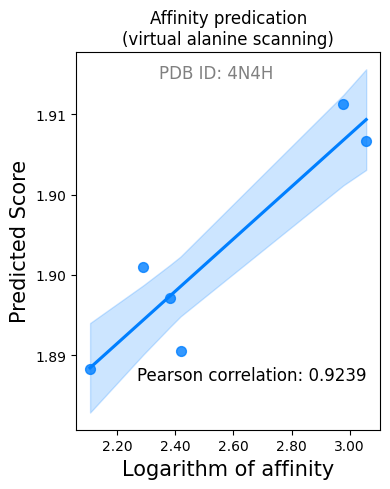

In [14]:
scores = model.evaluate(X_F4N4H, y_F4N4H)
F4N4H_predictions = model.predict(X_F4N4H).flatten()
F4N4H_labels = np.array(y_F4N4H).flatten()
F4N4H_predictions = np.array(F4N4H_predictions).flatten()
rmse = mean_squared_error(F4N4H_labels, F4N4H_predictions, squared=False)
r2 = r2_score(F4N4H_labels, F4N4H_predictions)
pearson_corr, _ = pearsonr(F4N4H_labels, F4N4H_predictions)

print(f'Loss: {scores[0]:.4f}, RMSE: {rmse:.4f}, Pearson Correlation: {pearson_corr:.4f}')


n4h_x = F4N4H_labels
n4h_y = F4N4H_predictions

n4h_corr = np.corrcoef(n4h_x, n4h_y)[0, 1]

def calculate_confidence_band(x, y, confidence=0.50):
    slope, intercept, _, _, std_err = linregress(x, y)
    y_pred = np.array(x) * slope + intercept
    n = len(x)
    t_value =   1.282 
    delta = t_value * std_err * np.sqrt(1 / n + (np.array(x) - np.mean(x))**2 / np.sum((np.array(x) - np.mean(x))**2))
    lower_band = y_pred - delta
    upper_band = y_pred + delta
    return y_pred, lower_band, upper_band

from matplotlib.ticker import FuncFormatter
y_pred_tmp, lower_tmp, upper_tmp = calculate_confidence_band(n4h_x, n4h_y)
plt.figure(figsize=(4, 5))
sns.regplot(x=n4h_x, y=n4h_y, color="#007FFF", ci=None, scatter_kws={'s': 50})
plt.fill_between(n4h_x, lower_tmp, upper_tmp, color="#007FFF", alpha=0.2, label="80% CI")
plt.title("Affinity predication\n(virtual alanine scanning)", fontsize=12)
plt.xlabel("Logarithm of affinity", fontsize=15)
plt.ylabel("Predicted Score", fontsize=15)
formatter = FuncFormatter(lambda x, _: f'{x:.2f}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.text(0.20, 0.17, f"Pearson correlation: {n4h_corr:.4f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.text(0.65, 0.92, "PDB ID: 4N4H", transform=plt.gca().transAxes,
         fontsize=12, ha='right', va='bottom', color='gray')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = build_model(2048, X_train)
model.load_weights("/pepTrans weight/ Virtual alanine scanning/alanine_Scanning_pepTrans2_Weights.h5")

(None, 1024, 1)
Weight decay:  0.0001


1/1 [==============================] - 0s 32ms/step
Loss: 2.9191, RMSE: 1.5361, Pearson Correlation: 0.4627


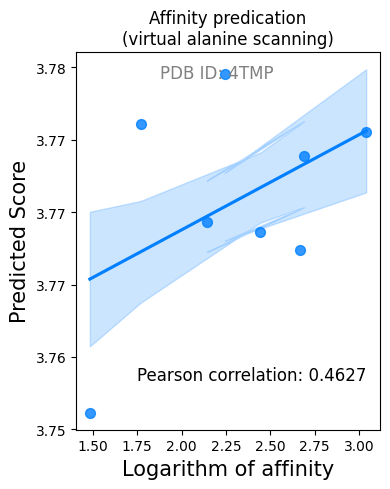

In [16]:
scores = model.evaluate(X_F4TMP, y_F4TMP)
F4TMP_predictions = model.predict(X_F4TMP).flatten()
F4TMP_labels = np.array(y_F4TMP).flatten()
F4TMP_predictions = np.array(F4TMP_predictions).flatten()
rmse = mean_squared_error(F4TMP_labels, F4TMP_predictions, squared=False)
r2 = r2_score(F4TMP_labels, F4TMP_predictions)
pearson_corr, _ = pearsonr(F4TMP_labels, F4TMP_predictions)

print(f'Loss: {scores[0]:.4f}, RMSE: {rmse:.4f}, Pearson Correlation: {pearson_corr:.4f}')

tmp_x = F4TMP_labels
tmp_y = F4TMP_predictions

tmp_corr = np.corrcoef(tmp_x, tmp_y)[0, 1]

def calculate_confidence_band(x, y, confidence=0.50):
    slope, intercept, _, _, std_err = linregress(x, y)
    y_pred = np.array(x) * slope + intercept
    n = len(x)
    t_value =   1.282 
    delta = t_value * std_err * np.sqrt(1 / n + (np.array(x) - np.mean(x))**2 / np.sum((np.array(x) - np.mean(x))**2))
    lower_band = y_pred - delta
    upper_band = y_pred + delta
    return y_pred, lower_band, upper_band



from matplotlib.ticker import FuncFormatter
y_pred_tmp, lower_tmp, upper_tmp = calculate_confidence_band(tmp_x, tmp_y)
plt.figure(figsize=(4, 5))
sns.regplot(x=tmp_x, y=tmp_y, color="#007FFF", ci=None, scatter_kws={'s': 50})
plt.fill_between(tmp_x, lower_tmp, upper_tmp, color="#007FFF", alpha=0.2, label="80% CI")
plt.title("Affinity predication\n(virtual alanine scanning)", fontsize=12)
plt.xlabel("Logarithm of affinity", fontsize=15)
plt.ylabel("Predicted Score", fontsize=15)
formatter = FuncFormatter(lambda x, _: f'{x:.2f}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.text(0.20, 0.17, f"Pearson correlation: {tmp_corr:.4f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.text(0.65, 0.92, "PDB ID: 4TMP", transform=plt.gca().transAxes,
         fontsize=12, ha='right', va='bottom', color='gray')
plt.tight_layout()
plt.show()


In [17]:
scores = model.evaluate(X_M6MIM, y_M6MIM)
M6MIM_predictions = model.predict(X_M6MIM).flatten()
M6MIM_labels = np.array(y_M6MIM).flatten()
M6MIM_predictions = np.array(M6MIM_predictions).flatten()
rmse = mean_squared_error(M6MIM_labels, M6MIM_predictions, squared=False)
r2 = r2_score(M6MIM_labels, M6MIM_predictions)
pearson_corr, _ = pearsonr(M6MIM_labels, M6MIM_predictions)

print(f'Loss: {scores[0]:.4f}, RMSE: {rmse:.4f}, Pearson Correlation: {pearson_corr:.4f}')

scores = model.evaluate(X_H5HJD, y_H5HJD)
H5HJD_predictions = model.predict(X_H5HJD).flatten()
H5HJD_labels = np.array(y_H5HJD).flatten()
H5HJD_predictions = np.array(H5HJD_predictions).flatten()
rmse = mean_squared_error(H5HJD_labels, H5HJD_predictions, squared=False)
r2 = r2_score(H5HJD_labels, H5HJD_predictions)
pearson_corr, _ = pearsonr(H5HJD_labels, H5HJD_predictions)

print(f'Loss: {scores[0]:.4f}, RMSE: {rmse:.4f}, Pearson Correlation: {pearson_corr:.4f}')

M6MIM_x = M6MIM_labels
M6MIM_y = M6MIM_predictions
H5HJD_x = H5HJD_labels
H5HJD_y = H5HJD_predictions

def calculate_confidence_band(x, yy, confidence=0.50):
    slope, intercept, _, _, std_err = linregress(x, yy)
    y_pred = np.array(x) * slope + intercept
    n = len(x)
    t_value = 1.282 
    delta = t_value * std_err * np.sqrt(1 / n + (np.array(x) - np.mean(x))**2 / np.sum((np.array(x) - np.mean(x))**2))
    lower_band = y_pred - delta
    upper_band = y_pred + delta
    return y_pred, lower_band, upper_band

M6MIM_corr = np.corrcoef(M6MIM_x, M6MIM_y)[0, 1]
H5HJD_corr = np.corrcoef(H5HJD_x, H5HJD_y)[0, 1]  



1/1 [==============================] - 0s 30ms/step
Loss: 1.0265, RMSE: 0.6835, Pearson Correlation: 0.8259
1/1 [==============================] - 0s 31ms/step
Loss: 0.8911, RMSE: 0.5760, Pearson Correlation: 0.7169


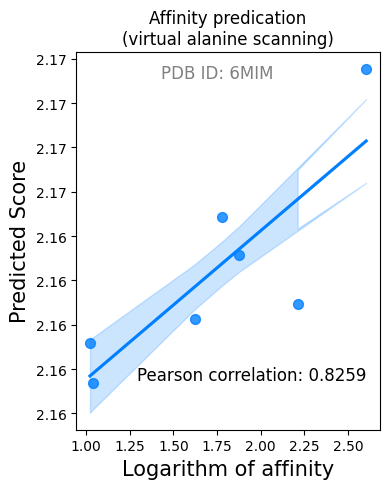

In [18]:
from matplotlib.ticker import FuncFormatter
y_pred_tmp, lower_tmp, upper_tmp = calculate_confidence_band(M6MIM_x, M6MIM_y)
plt.figure(figsize=(4, 5))
sns.regplot(x=M6MIM_x, y=M6MIM_y, color="#007FFF", ci=None, scatter_kws={'s': 50})
plt.fill_between(M6MIM_x, lower_tmp, upper_tmp, color="#007FFF", alpha=0.2, label="80% CI")
plt.title("Affinity predication\n(virtual alanine scanning)", fontsize=12)
plt.xlabel("Logarithm of affinity", fontsize=15)
plt.ylabel("Predicted Score", fontsize=15)
formatter = FuncFormatter(lambda x, _: f'{x:.2f}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.text(0.20, 0.17, f"Pearson correlation: {M6MIM_corr:.4f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.text(0.65, 0.92, "PDB ID: 6MIM", transform=plt.gca().transAxes,
         fontsize=12, ha='right', va='bottom', color='gray')
plt.tight_layout()
plt.show()

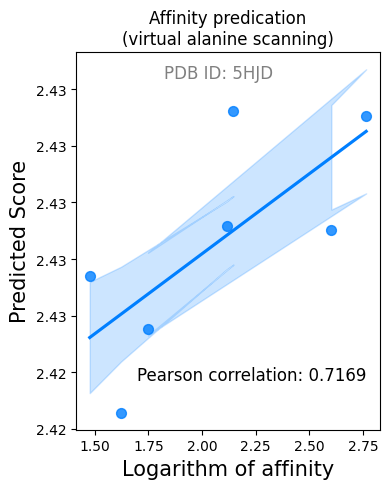

In [19]:
from matplotlib.ticker import FuncFormatter
y_pred_tmp, lower_tmp, upper_tmp = calculate_confidence_band(H5HJD_x, H5HJD_y)
plt.figure(figsize=(4, 5))
sns.regplot(x=H5HJD_x, y=H5HJD_y, color="#007FFF", ci=None, scatter_kws={'s': 50})
plt.fill_between(H5HJD_x, lower_tmp, upper_tmp, color="#007FFF", alpha=0.2, label="80% CI")
plt.title("Affinity predication\n(virtual alanine scanning)", fontsize=12)
plt.xlabel("Logarithm of affinity", fontsize=15)
plt.ylabel("Predicted Score", fontsize=15)
formatter = FuncFormatter(lambda x, _: f'{x:.2f}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.text(0.20, 0.17, f"Pearson correlation: {H5HJD_corr:.4f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.text(0.65, 0.92, "PDB ID: 5HJD", transform=plt.gca().transAxes,
         fontsize=12, ha='right', va='bottom', color='gray')
plt.tight_layout()
plt.show()